In [1]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [2]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()
len(words)

32033

In [3]:
b = {}
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


sorted(b.items(), key=lambda x: x[1], reverse=True)[:20]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422)]

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}


In [6]:
import torch

N = torch.zeros((27,27), dtype=torch.int32)
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (stoi[ch1], stoi[ch2])
        N[bigram] += 1


# frequency as probability

In [6]:
P = N / N.sum(dim=-1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

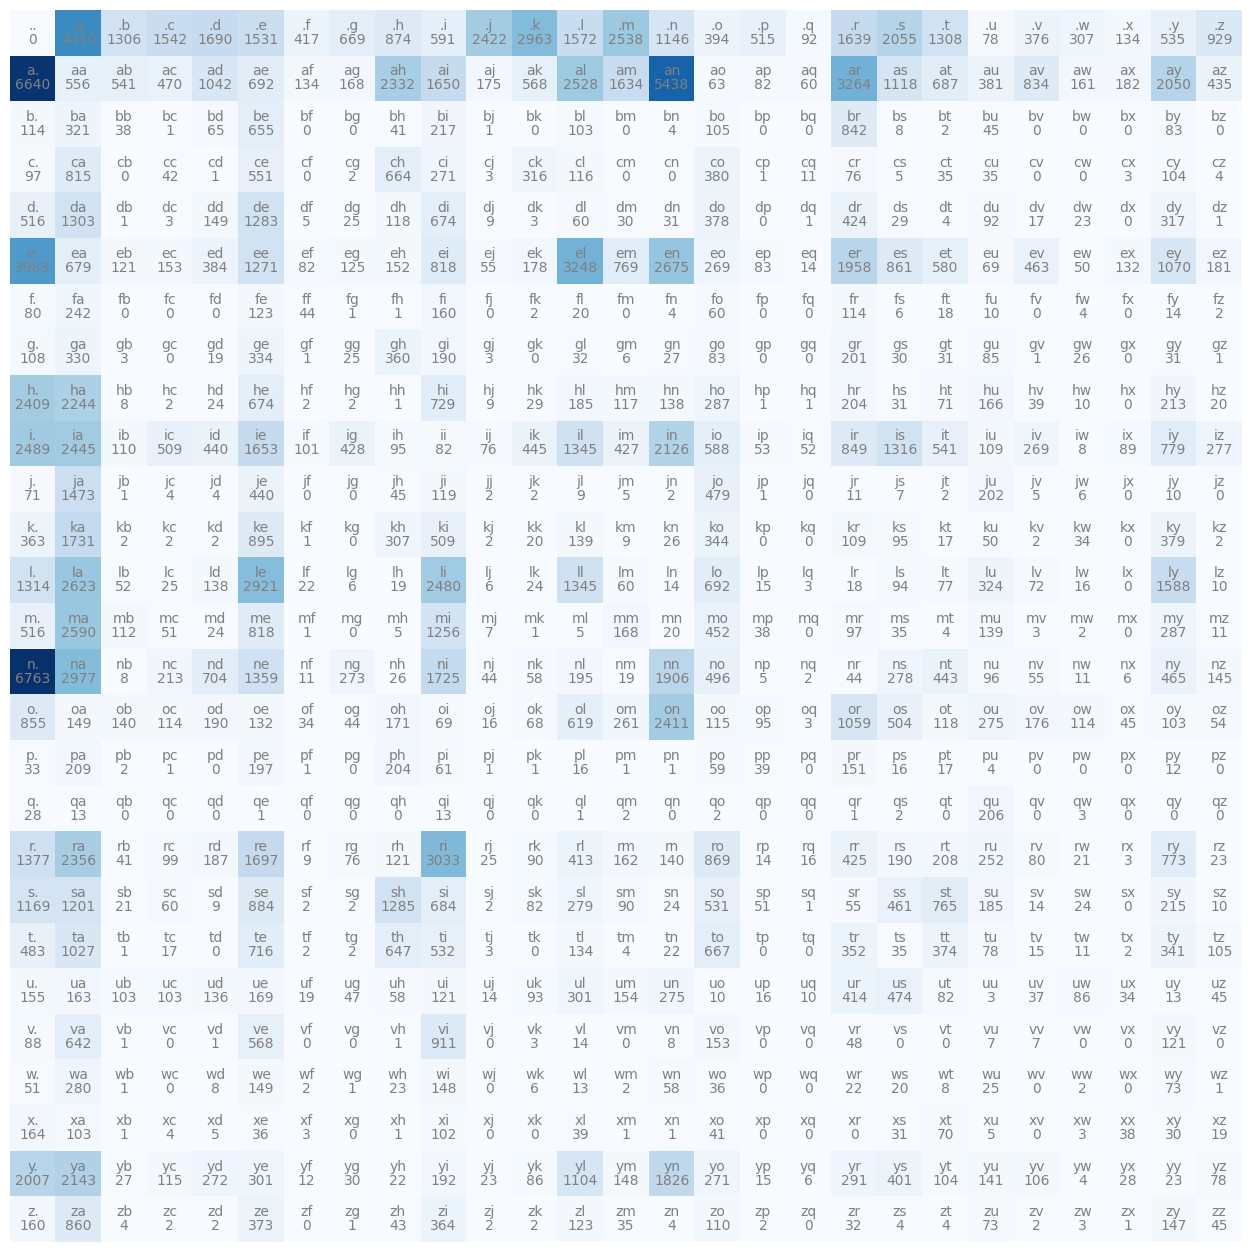

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis('off')

In [8]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.


In [9]:
nll = 0.0
n = 0
for w in ['xiaojq']:
    w = ['.'] + list(w) + ['.']
    for tk, next_tk in zip(w, w[1:]):
        prob = P[stoi[tk], stoi[next_tk]]
        print(f'{tk}{next_tk} prob: {prob:.4f} nll: {-prob.log():.4f}')
        nll += -prob.log()
        n += 1
print(f'{nll=}')
f'{nll/n=}'

.x prob: 0.0042 nll: 5.4767
xi prob: 0.1463 nll: 1.9218
ia prob: 0.1381 nll: 1.9796
ao prob: 0.0019 nll: 6.2876
oj prob: 0.0020 nll: 6.2063
jq prob: 0.0000 nll: inf
q. prob: 0.1029 nll: 2.2736
nll=tensor(inf)


'nll/n=tensor(inf)'

# use neural network to learn probability

In [10]:
# train set
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)

## use off-the-shelf torch api

In [11]:
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Embedding(27, 27),
    # nn.GELU(),
    # nn.Linear(27, 27),
)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.1)
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=512, shuffle=True)

for epoch in range(3):
    for step, (xb, yb) in enumerate(train_dataloader):
        loss = F.cross_entropy(net(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb in val_dataloader:
                    val_loss += F.cross_entropy(net(xb), yb)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')



epoch 0 step 0 train loss: 3.7871 val loss: 3.7252
epoch 0 step 100 train loss: 2.5253 val loss: 2.6259
epoch 0 step 200 train loss: 2.4354 val loss: 2.6145
epoch 0 step 300 train loss: 2.4578 val loss: 2.6171
epoch 0 step 400 train loss: 2.4352 val loss: 2.6190
epoch 0 step 500 train loss: 2.5201 val loss: 2.6070
epoch 0 step 600 train loss: 2.3029 val loss: 2.6207
epoch 0 step 700 train loss: 2.3635 val loss: 2.6249
epoch 0 step 800 train loss: 2.5306 val loss: 2.6360
epoch 0 step 900 train loss: 2.5563 val loss: 2.6135
epoch 0 step 1000 train loss: 2.4840 val loss: 2.6047
epoch 0 step 1100 train loss: 2.4941 val loss: 2.6182
epoch 0 step 1200 train loss: 2.5322 val loss: 2.6296
epoch 0 step 1300 train loss: 2.5314 val loss: 2.6131
epoch 0 step 1400 train loss: 2.4669 val loss: 2.6079
epoch 0 step 1500 train loss: 2.5142 val loss: 2.5965
epoch 0 step 1600 train loss: 2.6258 val loss: 2.6177
epoch 1 step 0 train loss: 2.4759 val loss: 2.6034
epoch 1 step 100 train loss: 2.5335 val los

In [12]:
# bigram val loss
val_loss = 0.0
num = 0
for xb, yb in val_dataloader:
    for x, y in zip(xb, yb):
        val_loss += -P[x.item(), y.item()].log()
        num += 1
val_loss /= num
print(f'bigram val loss: {val_loss:.4f}')


bigram val loss: 2.5687


In [13]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = net(idx[-1]).softmax(dim=-1)
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.a.
.feeenvi.
.s.
.aabidushan.
.sssa.
.silaylelah.
.mah.
.li.
.an.
.epican.


In [14]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.


(-0.5, 26.5, 26.5, -0.5)

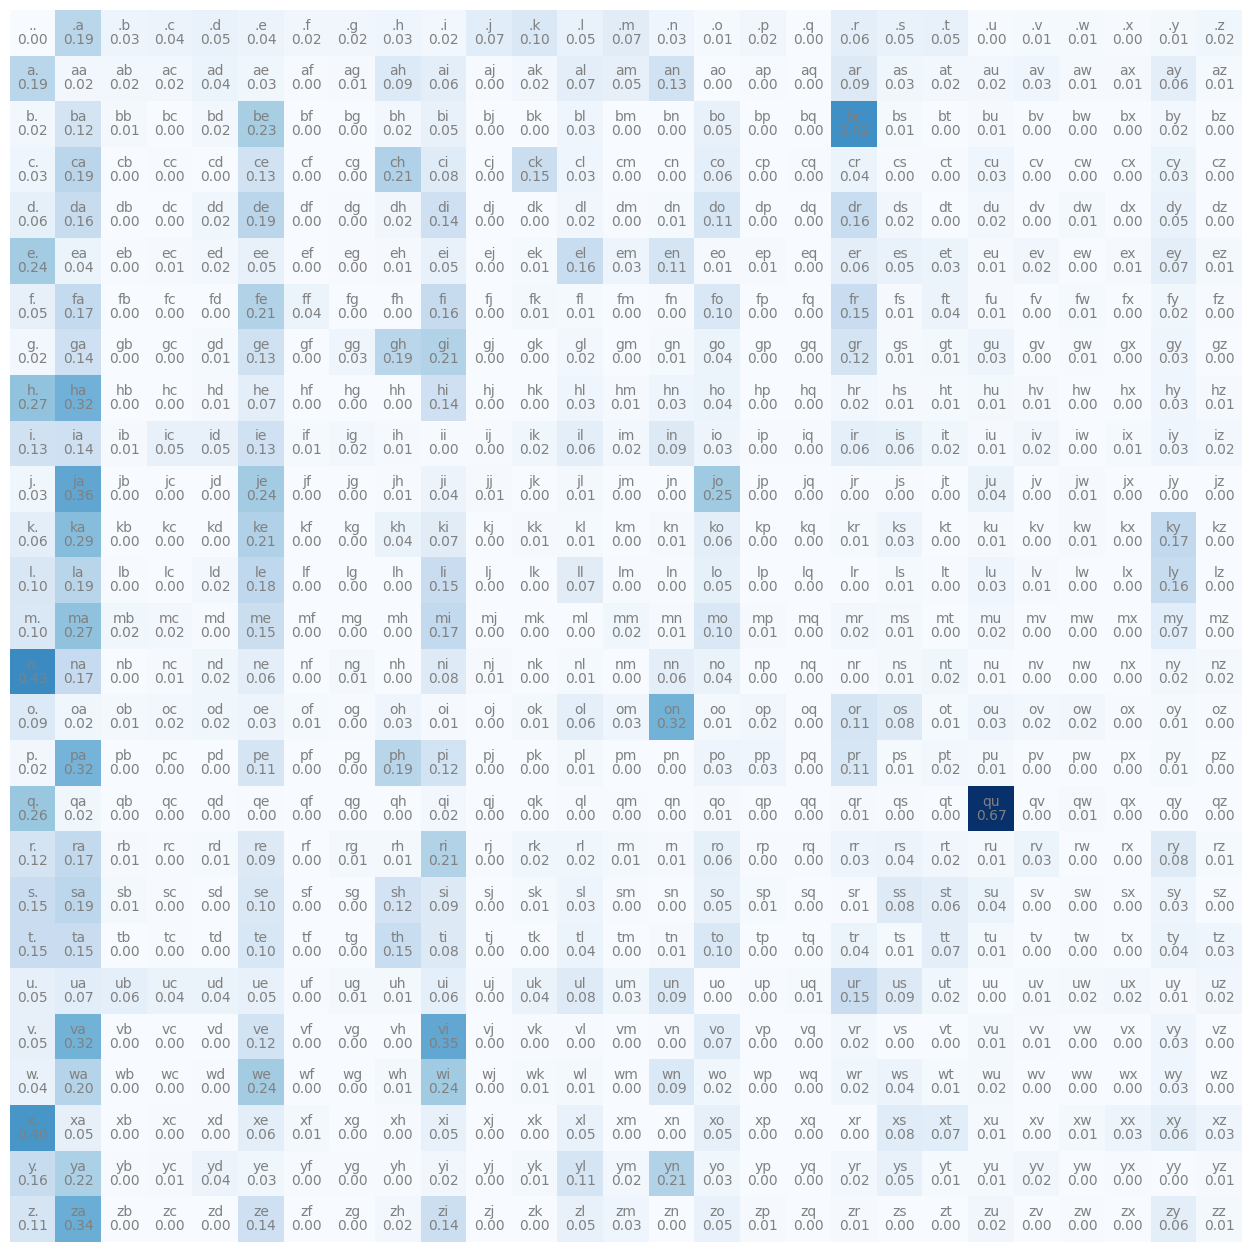

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

netP = net(torch.arange(27)).softmax(dim=-1).detach().numpy()
plt.figure(figsize=(16,16))
plt.imshow(netP, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{netP[i,j]:.2f}', ha="center", va="top", color="gray")

plt.axis('off')


(-0.5, 26.5, 26.5, -0.5)

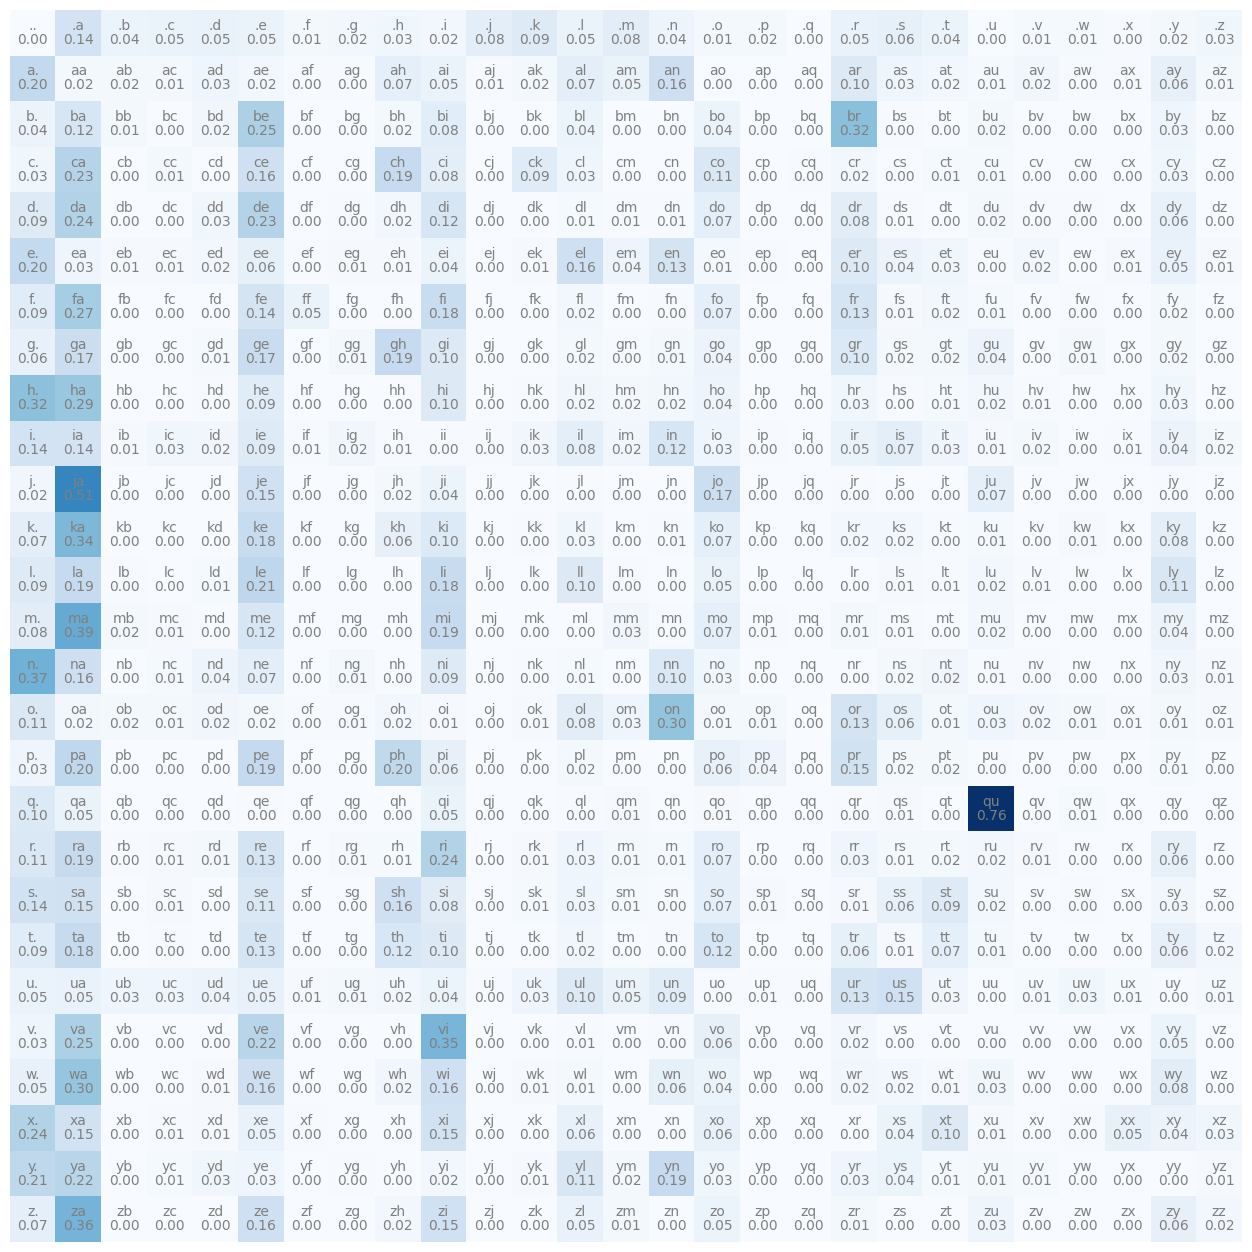

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{P[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

## use neural network from matrix multiplication

In [144]:
# from scratch
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), requires_grad=True, generator=g)


n = int(len(xs) * 0.95)
bs = 64

def cal_loss(xb, yb):
    xb = F.one_hot(xb, num_classes=27).float()
    logits = xb @ W
    exp_lg = logits.exp()
    probs = exp_lg / exp_lg.sum(dim=-1, keepdim=True)
    loss = -probs.gather(1, yb.unsqueeze(-1)).log().mean()
    return loss

lr = 0.2
step = 0
num_epochs = 5
for epoch in range(num_epochs):
    for idx in range(0, n, bs):
        xb, yb = xs[idx:idx+bs], ys[idx:idx+bs]
        loss = cal_loss(xb, yb)
        # update
        loss.backward()
        with torch.no_grad():
            W -= lr * W.grad
            W.grad = None
        step += 1
        if step % 100 == 0:
            with torch.no_grad():
                eval_loss = 0.0
                num = 0
                for idx in range(n, len(xs), bs):
                    xb, yb = xs[idx:idx+bs], ys[idx:idx+bs]
                    eval_loss += cal_loss(xb, yb)
                    num += 1
                eval_loss /= num
            print(f'epoch {epoch} step {step} loss: {loss:.4f} eval loss: {eval_loss:.4f}')




epoch 0 step 100 loss: 3.5045 eval loss: 3.6765
epoch 0 step 200 loss: 3.2001 eval loss: 3.5833
epoch 0 step 300 loss: 2.7962 eval loss: 3.5021
epoch 0 step 400 loss: 3.3651 eval loss: 3.4261
epoch 0 step 500 loss: 2.7977 eval loss: 3.3587
epoch 0 step 600 loss: 2.8413 eval loss: 3.3006
epoch 0 step 700 loss: 3.0461 eval loss: 3.2499
epoch 0 step 800 loss: 2.9352 eval loss: 3.2072
epoch 0 step 900 loss: 2.7186 eval loss: 3.1702
epoch 0 step 1000 loss: 2.9263 eval loss: 3.1380
epoch 0 step 1100 loss: 2.8188 eval loss: 3.1182
epoch 0 step 1200 loss: 2.8996 eval loss: 3.0929
epoch 0 step 1300 loss: 2.9683 eval loss: 3.0715
epoch 0 step 1400 loss: 2.6707 eval loss: 3.0540
epoch 0 step 1500 loss: 3.1692 eval loss: 3.0326
epoch 0 step 1600 loss: 2.8870 eval loss: 3.0286
epoch 0 step 1700 loss: 2.9739 eval loss: 3.0023
epoch 0 step 1800 loss: 2.5598 eval loss: 3.0099
epoch 0 step 1900 loss: 2.4330 eval loss: 2.9770
epoch 0 step 2000 loss: 2.3579 eval loss: 2.9645
epoch 0 step 2100 loss: 3.102

(-0.5, 26.5, 26.5, -0.5)

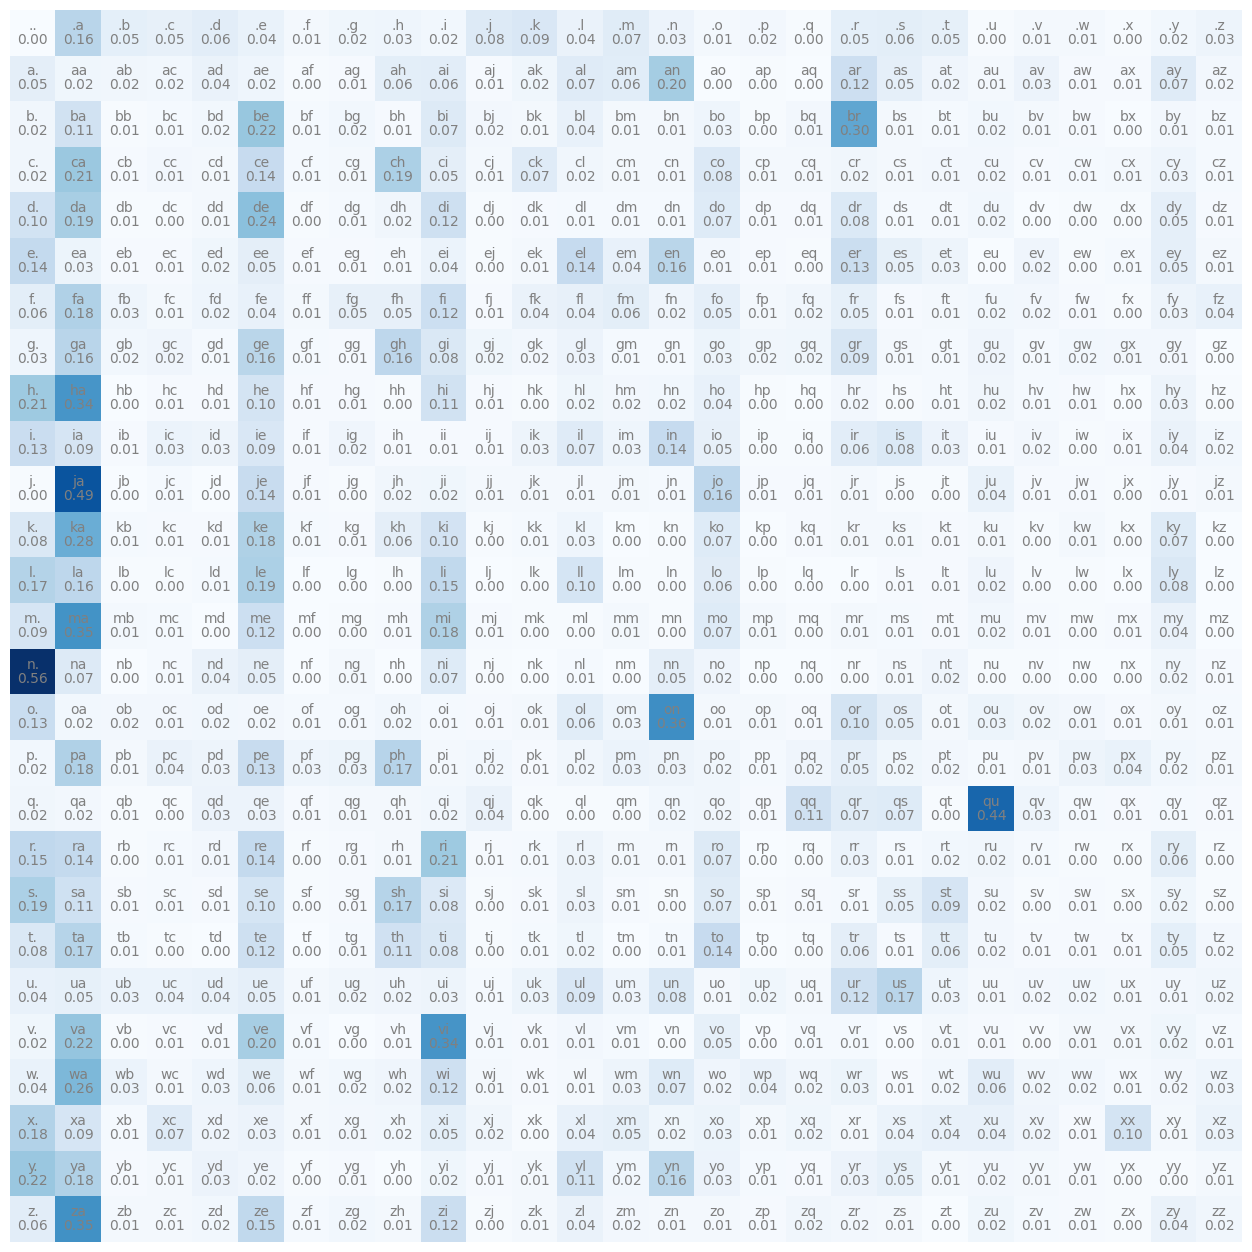

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

PW = W.detach().softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [149]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.an.
.geenvt.
.s.
.aabidushxfmesharillaylelaremah.
.li.
.an.
.epjachaden.
.diza.
.k.
.ach.


## use micrograd from scratch

In [7]:
# use micrograd from scratch
import random
from micrograd import Value

random.seed(42)
W = [[Value(random.gauss(0,1)) for _ in range(27)] for _ in range(27)]

def cal_loss(xb, yb):
    logits = [W[xb[i]] for i in range(len(xb))] # (bs, 27)
    exp_logits = [[lg.exp() for lg in logit] for logit in logits]
    sum_exp_logits = [sum(exp_logit) for exp_logit in exp_logits] # (bs,)
    probs = [exp_logit[y] / sum_exp_logit for exp_logit, sum_exp_logit, y in zip(exp_logits, sum_exp_logits, yb)]
    loss = sum([-prob.log() for prob in probs]) / len(probs)
    return loss

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
bs = 64
lr = 0.2

for step, idx in enumerate(range(0, n, bs)):
    xb, yb = zip(*train_data[idx:idx+bs])
    loss = cal_loss(xb, yb)
    # update
    loss.backward()
    for params in W:
        for p in params:
            p.data -= lr * p.grad
            p.grad = 0.0
    if step % 100 == 0:
        xb, yb = zip(*val_data[:bs]) # one batch for efficiency
        val_loss = cal_loss(xb, yb)
        print(f'step: {step} loss: {loss.data:.4f} val loss: {val_loss.data:.4f}')





step: 0 loss: 3.7595 val loss: 3.9411
step: 100 loss: 3.2954 val loss: 3.8277
step: 200 loss: 3.2459 val loss: 3.7512
step: 300 loss: 3.3527 val loss: 3.6978
step: 400 loss: 3.2461 val loss: 3.6471
step: 500 loss: 3.1277 val loss: 3.6016
step: 600 loss: 2.9676 val loss: 3.5641
step: 700 loss: 2.4875 val loss: 3.5305
step: 800 loss: 2.9317 val loss: 3.5069
step: 900 loss: 2.8386 val loss: 3.4845
step: 1000 loss: 3.0047 val loss: 3.4684
step: 1100 loss: 2.9006 val loss: 3.4639
step: 1200 loss: 2.7208 val loss: 3.4275
step: 1300 loss: 3.0257 val loss: 3.4100
step: 1400 loss: 2.5420 val loss: 3.4176
step: 1500 loss: 2.6783 val loss: 3.3930
step: 1600 loss: 2.5053 val loss: 3.3503
step: 1700 loss: 2.6508 val loss: 3.3574
step: 1800 loss: 2.1731 val loss: 3.3743
step: 1900 loss: 2.4066 val loss: 3.3106
step: 2000 loss: 2.4116 val loss: 3.3211
step: 2100 loss: 3.0233 val loss: 3.2540
step: 2200 loss: 2.7749 val loss: 3.1656
step: 2300 loss: 2.7691 val loss: 3.1113
step: 2400 loss: 2.8542 val 

(-0.5, 26.5, 26.5, -0.5)

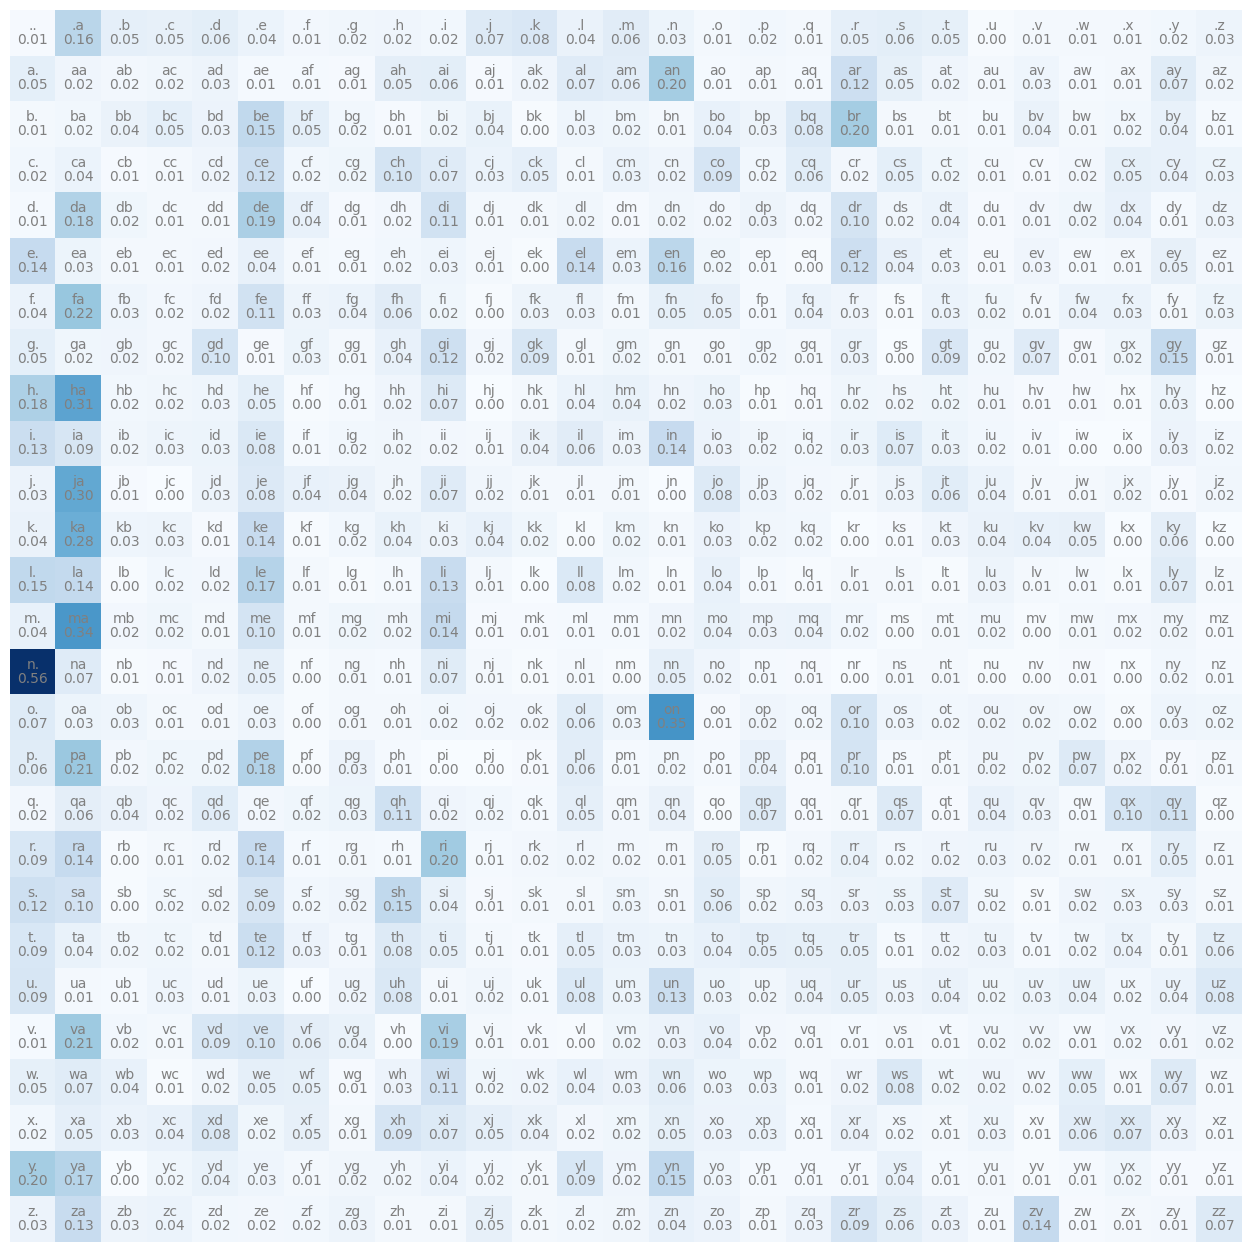

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

W_data = [[w.data for w in params] for params in W]
PW = torch.tensor(W_data).softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [13]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.an.
.gdenvgpa.
.aabiqu.
.dxfwshan.
.silaylelaremah.
.li.
.an.
.epwacenden.
.dszc.
.kjacmabondre.
